# 6. 영화리뷰 텍스트 감성분석하기

## 준비한 데이터
- 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus 데이터셋
- Pre-trained 한국어 Word2Vec 임베딩


### 1) 필요한데이터

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어

# 데이터 로더 함수 정의
def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)  
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  
    train_data['document'].replace('', np.nan, inplace=True)  
    train_data = train_data.dropna(how = 'any') 
    # test data 전처리
    test_data.drop_duplicates(subset=['document'], inplace=True)  
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  
    test_data['document'].replace('', np.nan, inplace=True)  
    test_data = test_data.dropna(how = 'any')  

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)  
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  
    word_to_index = {word:index for index, word in enumerate(vocab)}  #
    
    # 리뷰 텍스트를 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터 로더 실행하여 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

index_to_word = {index:word for word, index in word_to_index.items()}  

/tmp/ipykernel_87/4130442331.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_87/4130442331.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


train data 개수: 145791, test data 개수: 48995


In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


### 3) 모델 구성을 위한 데이터 분석 및 가공

In [5]:
# 텍스트 데이터 문장 길이의 리스트 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

print(X_train.shape)

(145791, 36)


In [7]:
# 훈련용 데이터셋 143681건 중 50000건을 분리하여 validation set으로 사용
x_val = X_train[:50000]
y_val = y_train[:50000]

# validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[50000:]
partial_y_train = y_train[50000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(50000, 36)
(50000,)
(95791, 36)
(95791,)


### 4) 모델별 학습,평가,시각화

#### (1) LSTM 모델

##### 모델설계


In [8]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
lstm_model = keras.Sequential(name="LSTM")
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
lstm_model.add(keras.layers.Dense(8, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

lstm_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


##### 모델 학습 및 평가

In [9]:
# model 학습
lstm_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = lstm_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 20s 9ms/step - loss: 0.5537 - accuracy: 0.6912 - val_loss: 0.3879 - val_accuracy: 0.8305
Epoch 2/5
188/188 [==============================] - 1s 7ms/step - loss: 0.3562 - accuracy: 0.8468 - val_loss: 0.3556 - val_accuracy: 0.8433
Epoch 3/5
188/188 [==============================] - 1s 7ms/step - loss: 0.3129 - accuracy: 0.8646 - val_loss: 0.3763 - val_accuracy: 0.8370
Epoch 4/5
188/188 [==============================] - 1s 7ms/step - loss: 0.2877 - accuracy: 0.8760 - val_loss: 0.3644 - val_accuracy: 0.8418
Epoch 5/5
188/188 [==============================] - 1s 7ms/step - loss: 0.2681 - accuracy: 0.8841 - val_loss: 0.3873 - val_accuracy: 0.8402


In [10]:
# test set으로 model 평가
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
print(lstm_results)

1532/1532 - 3s - loss: 0.3954 - accuracy: 0.8358
[0.3953649699687958, 0.8358199596405029]


##### 시각화

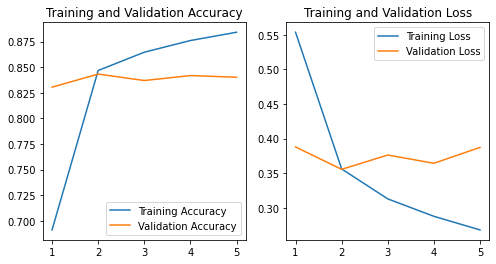

In [11]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### (2) 1-D CNN 모델

##### 모델설계

In [12]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(16, 3, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(16, 3, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          9616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9       

##### 모델 학습 및 평가

In [13]:
# model 학습
CNN_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = CNN_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 13s 8ms/step - loss: 0.4800 - accuracy: 0.7646 - val_loss: 0.3612 - val_accuracy: 0.8396
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 0.3232 - accuracy: 0.8622 - val_loss: 0.3495 - val_accuracy: 0.8481
Epoch 3/5
188/188 [==============================] - 1s 6ms/step - loss: 0.2694 - accuracy: 0.8909 - val_loss: 0.3630 - val_accuracy: 0.8457
Epoch 4/5
188/188 [==============================] - 1s 6ms/step - loss: 0.2213 - accuracy: 0.9145 - val_loss: 0.3896 - val_accuracy: 0.8413
Epoch 5/5
188/188 [==============================] - 1s 6ms/step - loss: 0.1733 - accuracy: 0.9374 - val_loss: 0.4442 - val_accuracy: 0.8343


In [14]:
# test set으로 model 평가
results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.4535 - accuracy: 0.8331
[0.453478068113327, 0.8331258296966553]


##### 시각화

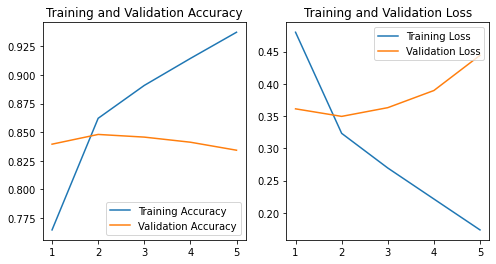

In [15]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### (3) GlobalMaxPooling1D

##### 모델설계

In [16]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
MaxPooling1D_model = keras.Sequential(name="GlabalMaxPooling1D")
MaxPooling1D_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
MaxPooling1D_model.add(keras.layers.GlobalMaxPooling1D())
MaxPooling1D_model.add(keras.layers.Dense(8, activation='relu'))
MaxPooling1D_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

MaxPooling1D_model.summary()

Model: "GlabalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


##### 모델 학습 및 평가

In [17]:
# model 학습
MaxPooling1D_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = MaxPooling1D_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
188/188 [==============================] - 1s 6ms/step - loss: 0.5116 - accuracy: 0.7839 - val_loss: 0.3662 - val_accuracy: 0.8377
Epoch 2/5
188/188 [==============================] - 1s 5ms/step - loss: 0.3319 - accuracy: 0.8579 - val_loss: 0.3484 - val_accuracy: 0.8462
Epoch 3/5
188/188 [==============================] - 1s 5ms/step - loss: 0.2803 - accuracy: 0.8850 - val_loss: 0.3516 - val_accuracy: 0.8476
Epoch 4/5
188/188 [==============================] - 1s 5ms/step - loss: 0.2386 - accuracy: 0.9062 - val_loss: 0.3659 - val_accuracy: 0.8466
Epoch 5/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1985 - accuracy: 0.9262 - val_loss: 0.3881 - val_accuracy: 0.8437


In [18]:
# test set으로 model 평가
results = MaxPooling1D_model.evaluate(X_test,  y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3975 - accuracy: 0.8401
[0.3975350558757782, 0.8400857448577881]


###### 시각화

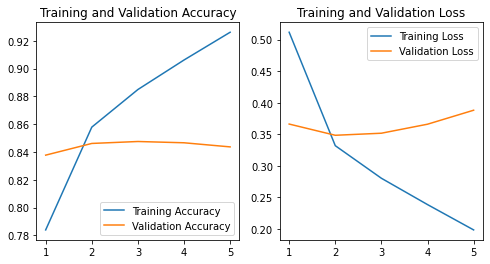

In [19]:
# 시각화할 항목 세팅
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### 결론

In [20]:
print("LSTM 모델의 성능")
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
print("CNN 모델의 성능")
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print("MaxPooling1D 모델의 성능")
MaxPooling1D_results = MaxPooling1D_model.evaluate(X_test,  y_test, verbose=2)

LSTM 모델의 성능
1532/1532 - 3s - loss: 0.3954 - accuracy: 0.8358
CNN 모델의 성능
1532/1532 - 3s - loss: 0.4535 - accuracy: 0.8331
MaxPooling1D 모델의 성능
1532/1532 - 2s - loss: 0.3975 - accuracy: 0.8401


거의 도찐개찐인거 같다.
하지만 로스의 값이 가장낮은 LSTM모델을 사용하겠다.

### 5) 학습된 Embedding 레이어 분석


In [21]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = lstm_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [22]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  


vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [23]:
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")

[('정석', 0.7896303534507751),
 ('명작', 0.788073718547821),
 ('픈', 0.7735989093780518),
 ('천재', 0.7667890787124634),
 ('애절', 0.7656669616699219),
 ('즐겼', 0.7608472108840942),
 ('깔끔', 0.7521629333496094),
 ('걸작', 0.7501651048660278),
 ('역작', 0.7453042268753052),
 ('굳', 0.745044469833374)]

### 6) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [24]:
from gensim.models import Word2Vec

In [26]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

In [27]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [28]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

#이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습
vocab_size = len(index_to_word)    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_87/2605392126.py:15: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_87/2605392126.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [29]:
from tensorflow.keras.initializers import Constant

# model 설계 
lstmk_model = keras.Sequential(name="LSTM-Kor")
lstmk_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
lstmk_model.add(keras.layers.LSTM(128)) #LSTM state 벡터의 차원수
lstmk_model.add(keras.layers.Dense(8, activation='relu'))
lstmk_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstmk_model.summary()

Model: "LSTM-Kor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 오버피팅 없애기
# 다른사람꺼 참조했다.
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
     
    
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


In [32]:
# 모델 학습 시작
lstmk_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=10

history = lstmk_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[es,mc])

Epoch 1/10
375/375 [==============================] - 5s 10ms/step - loss: 0.1674 - accuracy: 0.9349 - val_loss: 0.3994 - val_accuracy: 0.8495
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1434 - accuracy: 0.9459 - val_loss: 0.4150 - val_accuracy: 0.8498
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1228 - accuracy: 0.9552 - val_loss: 0.4727 - val_accuracy: 0.8477
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1058 - accuracy: 0.9623 - val_loss: 0.5060 - val_accuracy: 0.8477
Epoch 00004: early stopping


왜 미리 스탑하는거지?

In [33]:
# 학습 끝난 모델을 테스트셋으로 평가하기
lstmk_results = lstmk_model.evaluate(X_test,  y_test, verbose=2)

print(lstmk_results)

1532/1532 - 3s - loss: 0.5146 - accuracy: 0.8456
[0.5146295428276062, 0.845637321472168]
